This file contains python code to analysis the setting 
with permutation test to pick up the lambda



In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number
import multiprocessing as mp

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
import itertools
from scipy.stats import chi2


In [3]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [4]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT

from hdf_utils.hypo_test import obt_test_stat_simple2, get_Amat
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv
from utils.misc import save_pkl, load_pkl, get_local_min_idxs
from optimization.one_step_opt import OneStepOpt

from joblib import Parallel, delayed

In [5]:
import logging

logger = logging.getLogger("tmp")
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler() # for console. 
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)

logger.addHandler(ch)

In [6]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_tensor_type(torch.DoubleTensor)

# Param and fns

## Fns

In [7]:
def _get_min_idx(x):
    """Get the index of the minimal values among the local minimals.
       If there are multiple ones, return the largest index
       args:
           x: a vec
        
    """
    x = np.array(x)
    lmin_idxs = get_local_min_idxs(x);
    if len(lmin_idxs) == 0:
        lmin_idxs = np.arange(len(x))
    lmin_idxs_inv =  lmin_idxs[::-1]
    lmins_inv = x[lmin_idxs_inv];
    return  lmin_idxs_inv[np.argmin(lmins_inv)]
_err_fn = lambda x: np.nanmean(x**2)

<function __main__.<lambda>(x)>

# Analysis

In [8]:

c1s = [0.0, 0.2, 0.4]
can_Ns = [4, 6, 8]
setting = "setting4g"
can_lams = [0.001, 0.1, 0.3, 0.35, 0.40, 0.45, 0.50, 0.55, 0.6, 0.65, 0.7, 0.75, 0.80, 1.0, 2.0, 4.0, 16.0]

Cmat = np.eye(1) # change it depending on test1, test2, test3

num_rep = 200;

In [9]:
def _get_optlamN_perseed(rej_rate_mat):
    diff = np.abs(rej_rate_mat-0.05)
    optlamNs = []
    for Nidx, dif in enumerate(diff):
        min_idx = _get_min_idx(dif)
        optlamNs.append((can_Ns[Nidx], can_lams[min_idx], dif[min_idx]))
    optN, optlam, _ = sorted(optlamNs, key=lambda x: x[-1])[0]
    return optN, optlam

In [10]:
def _get_rej_rate(res_perm, idx=0):
    """idx: results index, either 0 or 1
    """
    pvals = np.array([re[idx].pval for re in res_perm])
    return np.mean(pvals<0.05)

## test_fn1

In [11]:
c1 = 0.0
idx = 1
def _run_fn(seed):
    rej_rate_mat = np.zeros((len(can_Ns), len(can_lams)));
    for Nidx, cur_N in enumerate(can_Ns):
        for lamidx, cur_lam in enumerate(can_lams):
            f_fil = list(cur_save_dir.glob(f"seed_{seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}-c1_{c1*1000:.0f}_perm_est.pkl"))[0]
            _, res_perm = load_pkl(f_fil, verbose=False);
            rej_rate_mat[Nidx, lamidx] = _get_rej_rate(res_perm, idx=idx)
    return rej_rate_mat
cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
with Parallel(n_jobs=20) as parallel:
    rej_rate_mats = parallel(delayed(_run_fn)(seed) for seed in tqdm(range(num_rep), total=num_rep))
rej_rate_mats = np.array(rej_rate_mats);

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.25it/s]


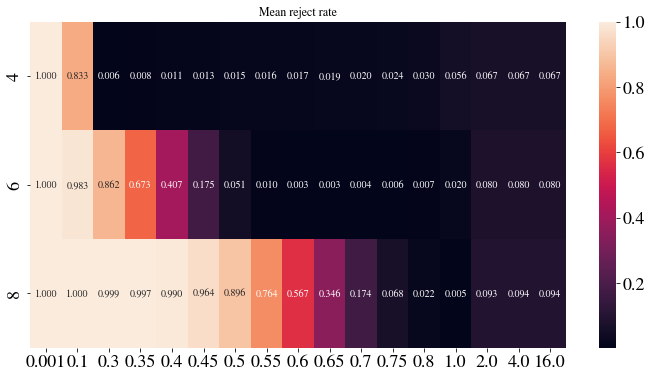

In [12]:
plt.figure(figsize=[12, 6])
sns.heatmap(rej_rate_mats.mean(axis=0), annot=rej_rate_mats.mean(axis=0), fmt=".3f")
plt.title("Mean reject rate")
plt.xticks(np.arange(len(can_lams))+0.5, can_lams);
plt.yticks(np.arange(len(can_Ns))+0.5, can_Ns);

In [13]:
optlamNs = np.array([_get_optlamN_perseed(rej_rate_mat) for rej_rate_mat in rej_rate_mats]);
combs, cts = np.unique(optlamNs, return_counts=1, axis=0);
np.concatenate([combs, cts.reshape(-1, 1)], axis=1)

array([[ 4.  ,  0.65,  4.  ],
       [ 4.  ,  0.7 ,  2.  ],
       [ 4.  ,  0.75, 10.  ],
       [ 4.  ,  0.8 , 31.  ],
       [ 4.  ,  1.  , 61.  ],
       [ 4.  , 16.  ,  5.  ],
       [ 6.  ,  0.4 ,  1.  ],
       [ 6.  ,  0.45,  7.  ],
       [ 6.  ,  0.5 , 23.  ],
       [ 6.  ,  0.55,  9.  ],
       [ 6.  ,  1.  ,  5.  ],
       [ 8.  ,  0.65,  4.  ],
       [ 8.  ,  0.7 ,  8.  ],
       [ 8.  ,  0.75, 17.  ],
       [ 8.  ,  0.8 , 11.  ],
       [ 8.  ,  2.  ,  2.  ]])

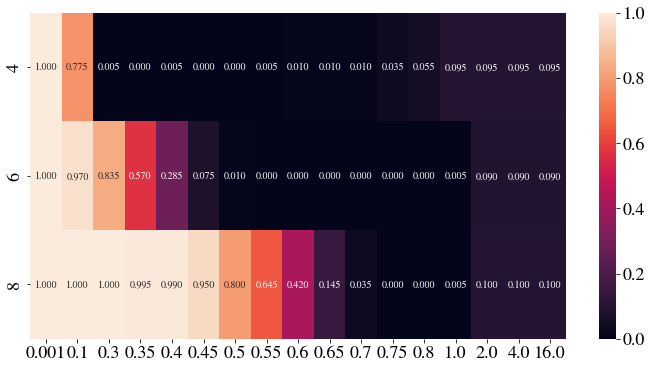

In [14]:
plt.figure(figsize=[12, 6])
seed_num = 100
sns.heatmap(rej_rate_mats[seed_num], annot=rej_rate_mats[seed_num], fmt=".3f")
plt.xticks(np.arange(len(can_lams))+0.5, can_lams);
plt.yticks(np.arange(len(can_Ns))+0.5, can_Ns);

In [15]:
pvals = [] 
for cur_seed, (cur_N, cur_lam) in enumerate(optlamNs):
    f_fil = list(cur_save_dir.glob(f"seed_{cur_seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}-c1_{c1*1000:.0f}_perm_est.pkl"))[0]
    res, _= load_pkl(f_fil, verbose=False);
    pvals.append(res[idx].pval)
pvals = np.array(pvals);
print(f"The size is {np.mean(pvals<0.05):.3f}.")

The size is 0.505.


The size is 0.445


## test_fn

In [16]:
c1 = 0
idx = 0
def _run_fn(seed):
    rej_rate_mat = np.zeros((len(can_Ns), len(can_lams)));
    for Nidx, cur_N in enumerate(can_Ns):
        for lamidx, cur_lam in enumerate(can_lams):
            f_fil = list(cur_save_dir.glob(f"seed_{seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}-c1_{c1*1000:.0f}_perm_est.pkl"))[0]
            _, res_perm = load_pkl(f_fil, verbose=False);
            rej_rate_mat[Nidx, lamidx] = _get_rej_rate(res_perm, idx=idx)
    return rej_rate_mat
cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
with Parallel(n_jobs=5) as parallel:
    rej_rate_mats = parallel(delayed(_run_fn)(seed) for seed in tqdm(range(num_rep), total=num_rep))
rej_rate_mats = np.array(rej_rate_mats);

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:20<00:00,  9.81it/s]


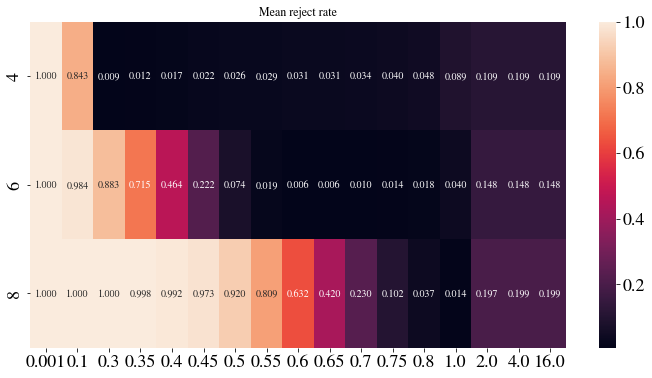

In [17]:
plt.figure(figsize=[12, 6])
sns.heatmap(rej_rate_mats.mean(axis=0), annot=rej_rate_mats.mean(axis=0), fmt=".3f")
plt.title("Mean reject rate")
plt.xticks(np.arange(len(can_lams))+0.5, can_lams);
plt.yticks(np.arange(len(can_Ns))+0.5, can_Ns);

In [18]:
optlamNs = np.array([_get_optlamN_perseed(rej_rate_mat) for rej_rate_mat in rej_rate_mats]);
combs, cts = np.unique(optlamNs, return_counts=1, axis=0);
np.concatenate([combs, cts.reshape(-1, 1)], axis=1)

array([[ 4.  ,  0.45,  1.  ],
       [ 4.  ,  0.5 ,  5.  ],
       [ 4.  ,  0.55,  5.  ],
       [ 4.  ,  0.6 ,  6.  ],
       [ 4.  ,  0.65, 10.  ],
       [ 4.  ,  0.7 , 10.  ],
       [ 4.  ,  0.75, 27.  ],
       [ 4.  ,  0.8 , 54.  ],
       [ 4.  ,  1.  , 18.  ],
       [ 4.  , 16.  ,  1.  ],
       [ 6.  ,  0.45,  1.  ],
       [ 6.  ,  0.5 , 21.  ],
       [ 6.  ,  0.55,  5.  ],
       [ 6.  ,  0.6 ,  1.  ],
       [ 6.  ,  0.75,  1.  ],
       [ 6.  ,  0.8 ,  1.  ],
       [ 6.  ,  1.  , 14.  ],
       [ 8.  ,  0.65,  1.  ],
       [ 8.  ,  0.7 ,  2.  ],
       [ 8.  ,  0.75,  8.  ],
       [ 8.  ,  0.8 ,  8.  ]])

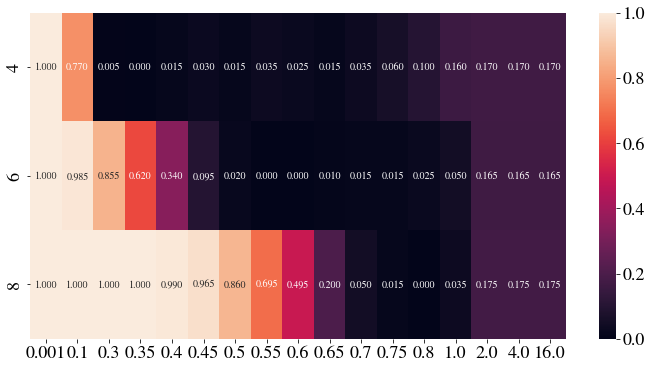

In [19]:
plt.figure(figsize=[12, 6])
seed_num = 100
sns.heatmap(rej_rate_mats[seed_num], annot=rej_rate_mats[seed_num], fmt=".3f")
plt.xticks(np.arange(len(can_lams))+0.5, can_lams);
plt.yticks(np.arange(len(can_Ns))+0.5, can_Ns);

In [20]:
pvals = [] 
for cur_seed, (cur_N, cur_lam) in enumerate(optlamNs):
    f_fil = list(cur_save_dir.glob(f"seed_{cur_seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}-c1_{c1*1000:.0f}_perm_est.pkl"))[0]
    res, _= load_pkl(f_fil, verbose=False);
    pvals.append(res[idx].pval)
pvals = np.array(pvals);
print(f"The size is {np.mean(pvals<0.05):.3f}.")

The size is 0.470.


In [108]:
kpidx = np.bitwise_and(all_coms[:, 0]==1e-7, all_coms[:, 1]==1e-8);
Tvs = opt_ress[:, kpidx, 0].reshape(-1)
pvals = opt_ress[:, kpidx, 1].reshape(-1);

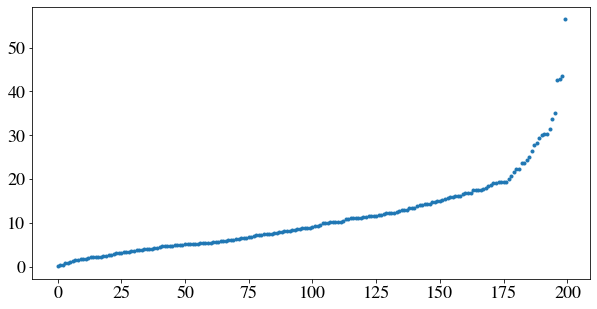

In [109]:
plt.figure(figsize=[10, 5])
plt.plot(np.sort(Tvs), ".")

In [ ]:
opt[pvals<0.05], Tvs[pvals<0.05]

In [111]:
mat1 = np.zeros((len(can_Ns), len(can_lams)))
mat2 = np.zeros((len(can_Ns), len(can_lams)))
for lamN, pval in zip(opt, pvals):
    if pval >= 0.05:
        mat1[can_Ns.index(lamN[1]), can_lams.index(lamN[2])] += 1
    else:
        mat2[can_Ns.index(lamN[1]), can_lams.index(lamN[2])] += 1

Text(970.2, 0.5, 'N')

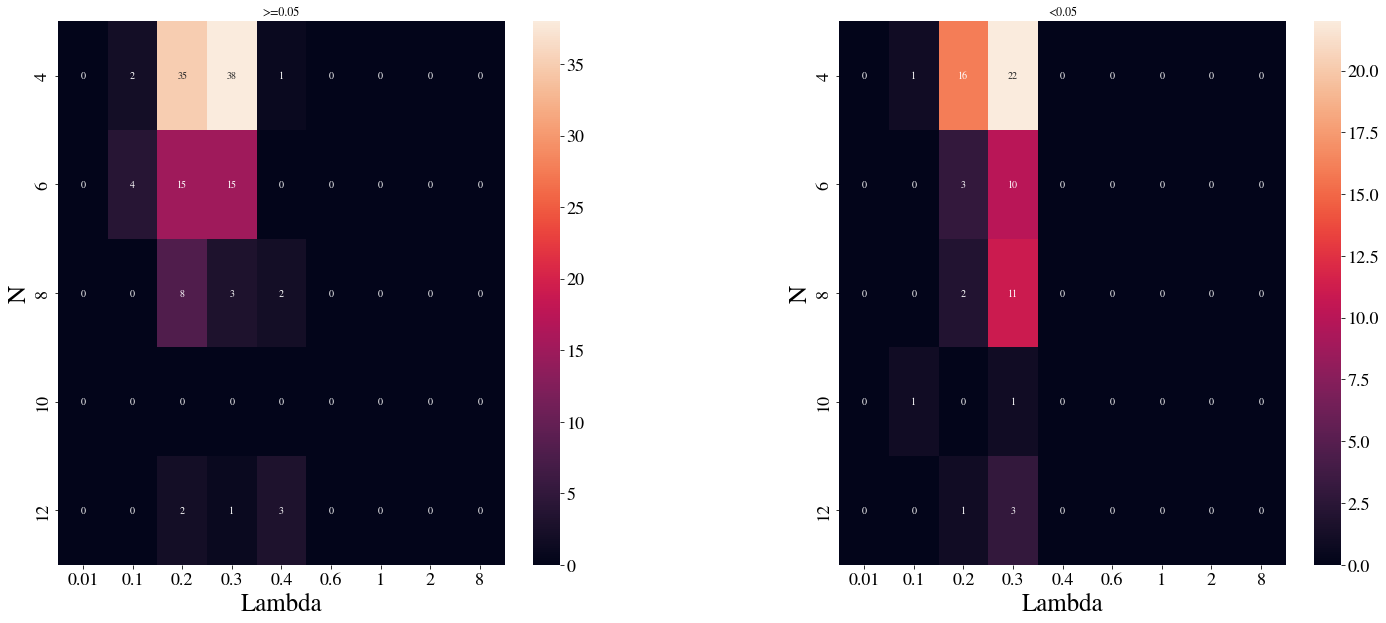

In [112]:
plt.figure(figsize=[24, 10])
plt.subplot(121)
plt.title(">=0.05")
sns.heatmap(mat1, annot=True)
plt.yticks(np.arange(len(can_Ns))+0.5, can_Ns);
plt.xticks(np.arange(len(can_lams))+0.5, can_lams);
plt.xlabel("Lambda")
plt.ylabel("N")

plt.subplot(122)
plt.title("<0.05")
sns.heatmap(mat2, annot=True)
plt.yticks(np.arange(len(can_Ns))+0.5, can_Ns);
plt.xticks(np.arange(len(can_lams))+0.5, can_lams);
plt.xlabel("Lambda")
plt.ylabel("N")